In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter3_"

loss_list = []
normalized_loss_list = []

print(datetime.datetime.now())

2023-06-22 07:37:32.327043


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae2_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae2_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter2")

dec: h_dim 64
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter2 ckpt_iwvi_pendulum_policy_optimization_iter2
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter2
base load self.initial_belief.data.sum() tensor(0.1670)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-3.9411)
penalty_target_min tensor(-6.1620) penalty_target_max tensor(32.2836)
train_loss:  -4.46739479828179
valid_loss:  -4.264854302310943
h_min_tilde -6.162006 ell_tilde -4.42688669908762 kappa_tilde 0.0007591635394861324
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter2
train_loss:  -0.8608980396896599
valid_loss:  -0.6103767992138863
weight_alpha 1.0 h_min_tilde -6.162006 ell_tilde -0.8107937915945053 kappa_tilde 0.0004322887337175578


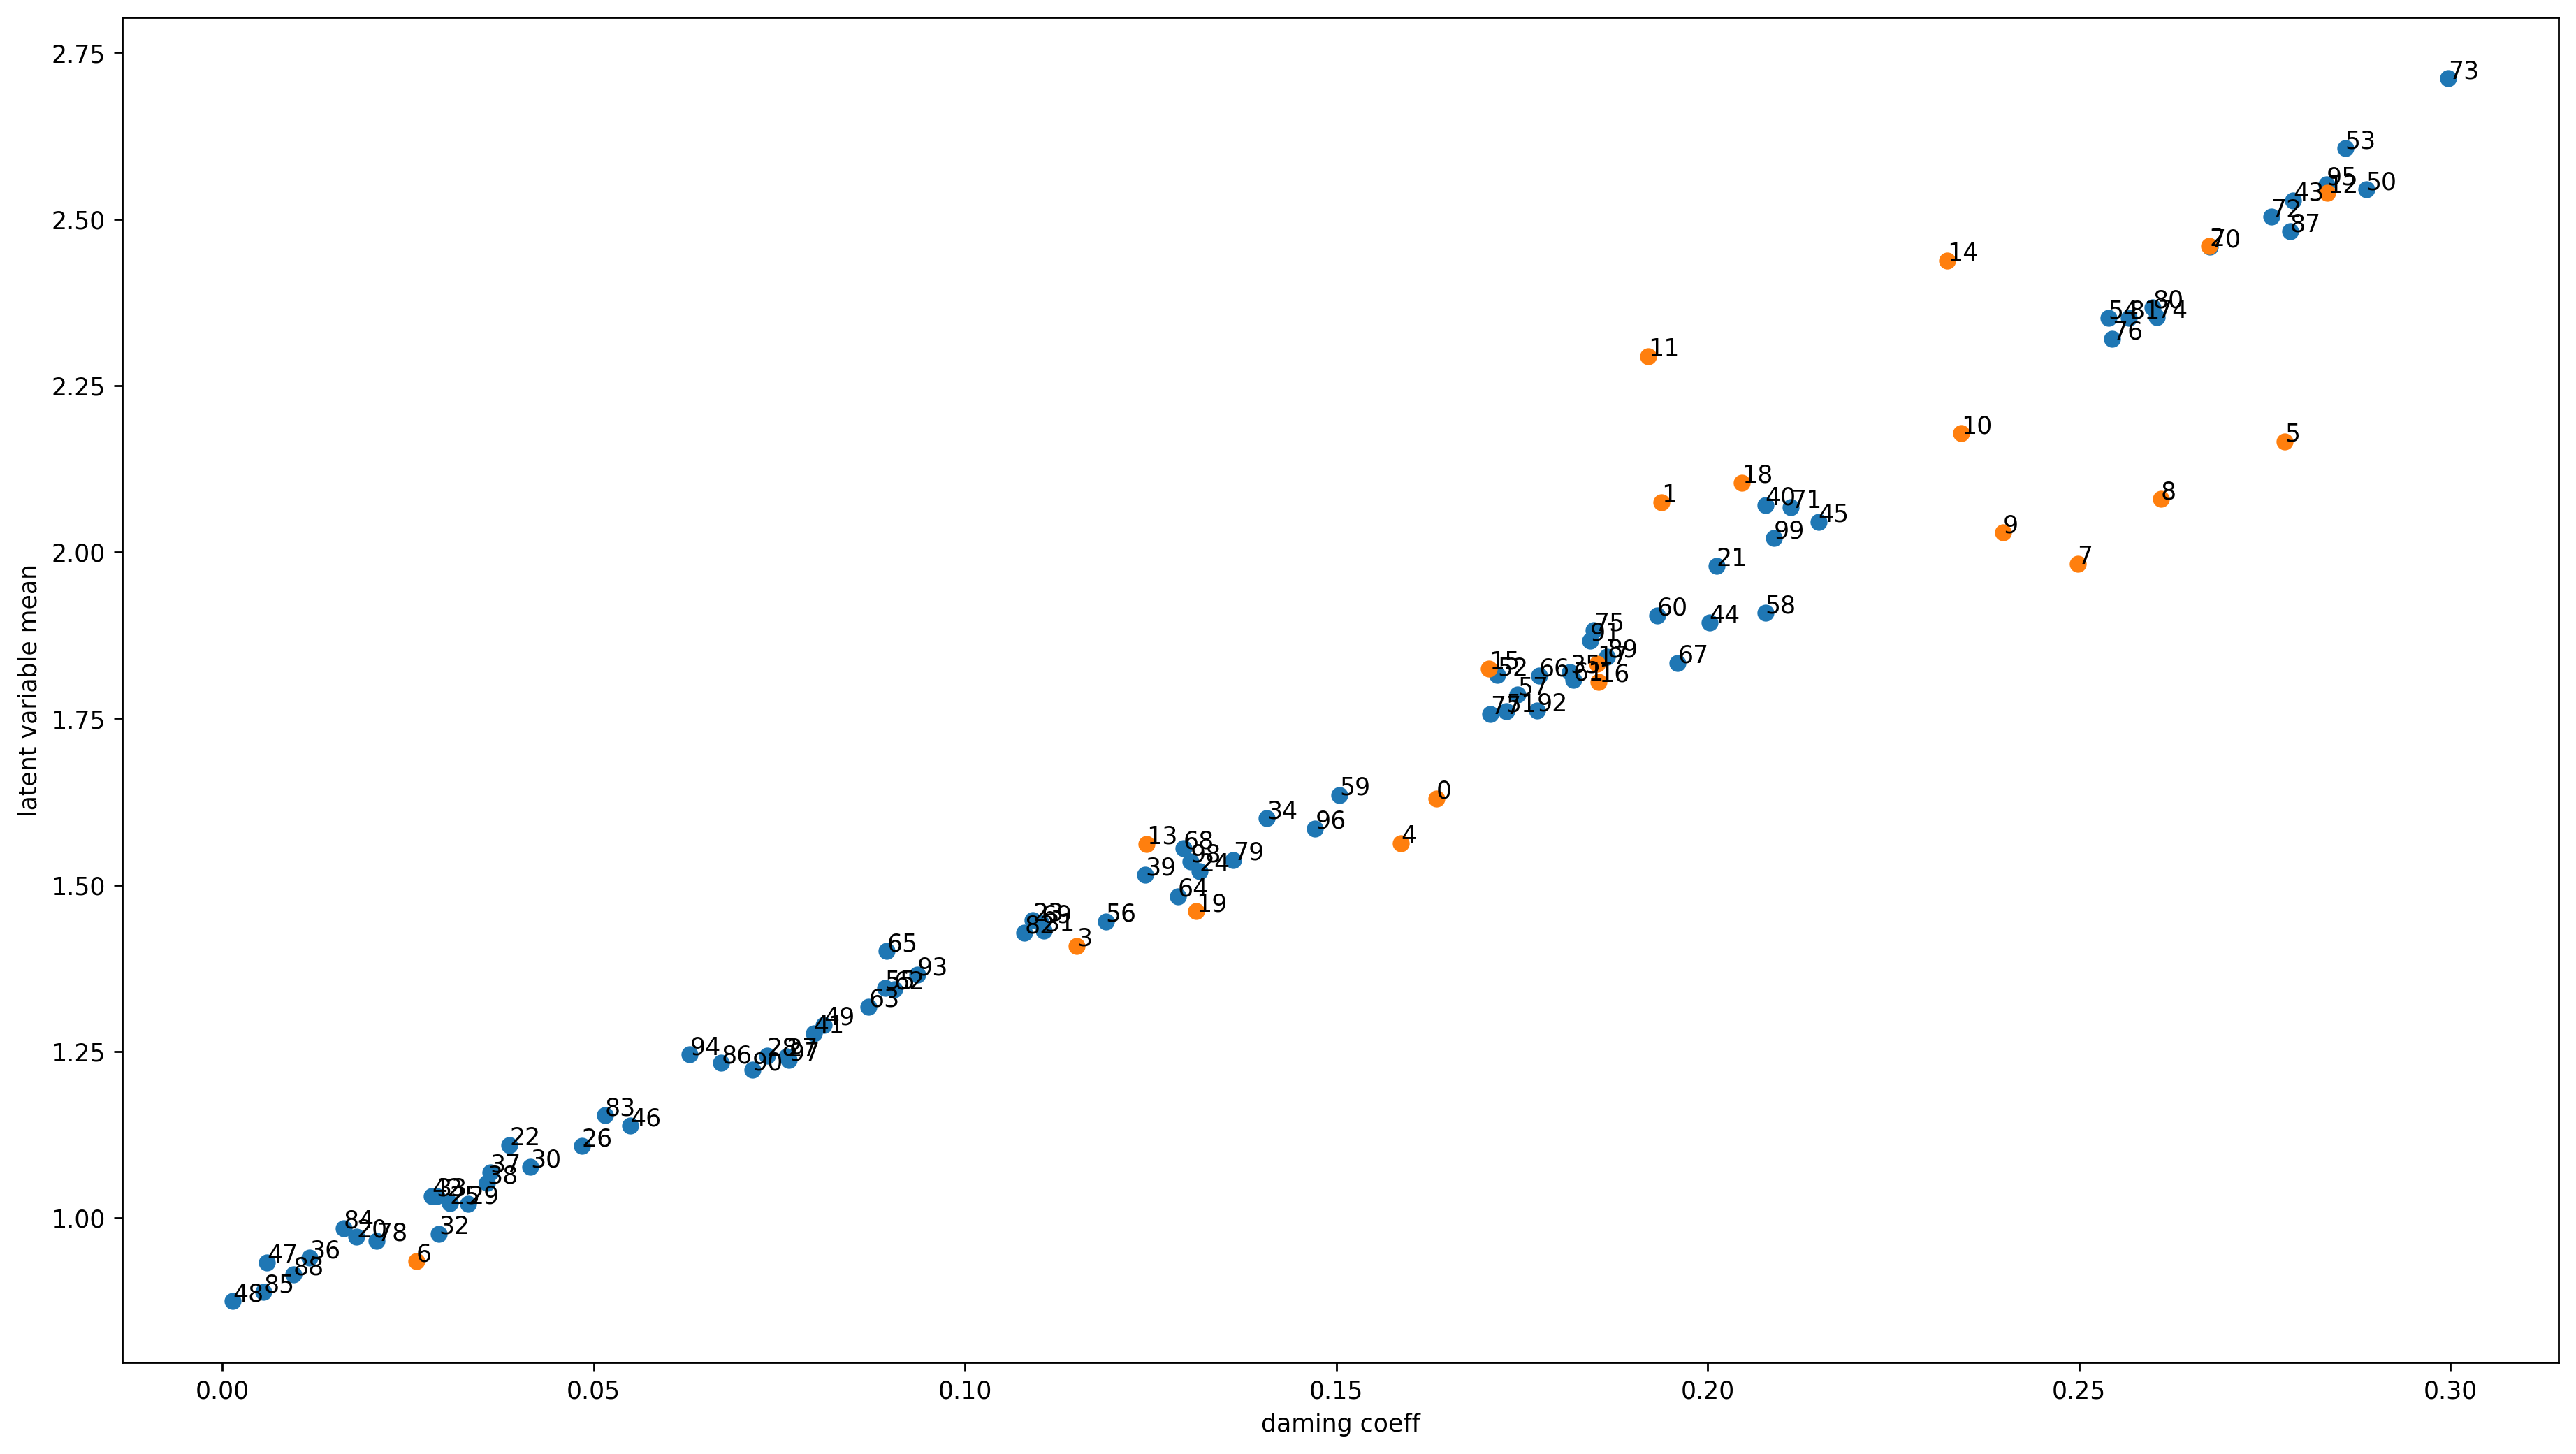

[0.16346495 0.19376823 0.2675319  0.11503246 0.15866848 0.27767899
 0.02613879 0.24978595 0.26100364 0.23974757]
[0.23415875 0.19197631 0.28340068 0.12439858 0.23227011 0.17053018
 0.18529065 0.1850802  0.20454609 0.13110959]
[0.01806764 0.20119136 0.03867789 0.10911323 0.13158045 0.03061344
 0.04839286 0.07598748 0.07332768 0.03311254]
[0.04145489 0.11061755 0.02913038 0.02882952 0.14059536 0.18145366
 0.01175634 0.03605897 0.03561832 0.1242789 ]
[0.20774164 0.07961685 0.02818215 0.27878886 0.20022311 0.21489816
 0.05495741 0.00603226 0.00140864 0.08100239]
[0.28865656 0.1728472  0.17167557 0.2858247  0.2539226  0.08923109
 0.11895172 0.17438186 0.20775948 0.15039731]
[0.19319706 0.18191796 0.09047245 0.08702328 0.12863061 0.0894847
 0.17726183 0.19596025 0.12942553 0.11026856]
[0.26757701 0.21116658 0.27584478 0.2996541  0.26043782 0.18466787
 0.25440247 0.17073022 0.0207501  0.1360628 ]
[0.2599147  0.256741   0.10799342 0.0514889  0.0163014  0.00555654
 0.06717741 0.27842439 0.00955

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 3.147217273712158

 2 3.4039013385772705

 3 3.372157573699951

 4 3.1659839153289795

 5 3.1855058670043945

 6 3.1760685443878174

 7 3.0673828125

 8 3.234005928039551

 9 3.207625150680542

 10 3.1671528816223145

 11 3.122615337371826

 12 3.2177226543426514

 13 3.2223873138427734

 14 3.0983054637908936

 15 3.2107014656066895

 16 3.0739643573760986

 17 3.222168445587158

 18 3.1595559120178223

 19 3.205749988555908

 20 3.1296274662017822

 21 3.048541307449341

 22 3.2577900886535645

 23 3.2129011154174805

 24 3.090214490890503

 25 3.1015493869781494

 26 3.2866766452789307

 27 3.2258083820343018

 28 3.0406062602996826

 29 3.1222853660583496

 30 3.1439971923828125

 31 3.2645370960235596

 32 3.1835951805114746

 33 3.1181387901306152

 34 3.1504037380218506

 35 3.0918235778808594

 36 3.1180660724639893

 37 3.1530585289001465

 38 3.0961341857910156

 39 3.060718536376953

 40 3.1084370613098145

 41 3.2608931064605713

 42 3.100757360458374

 43 3.33051371574

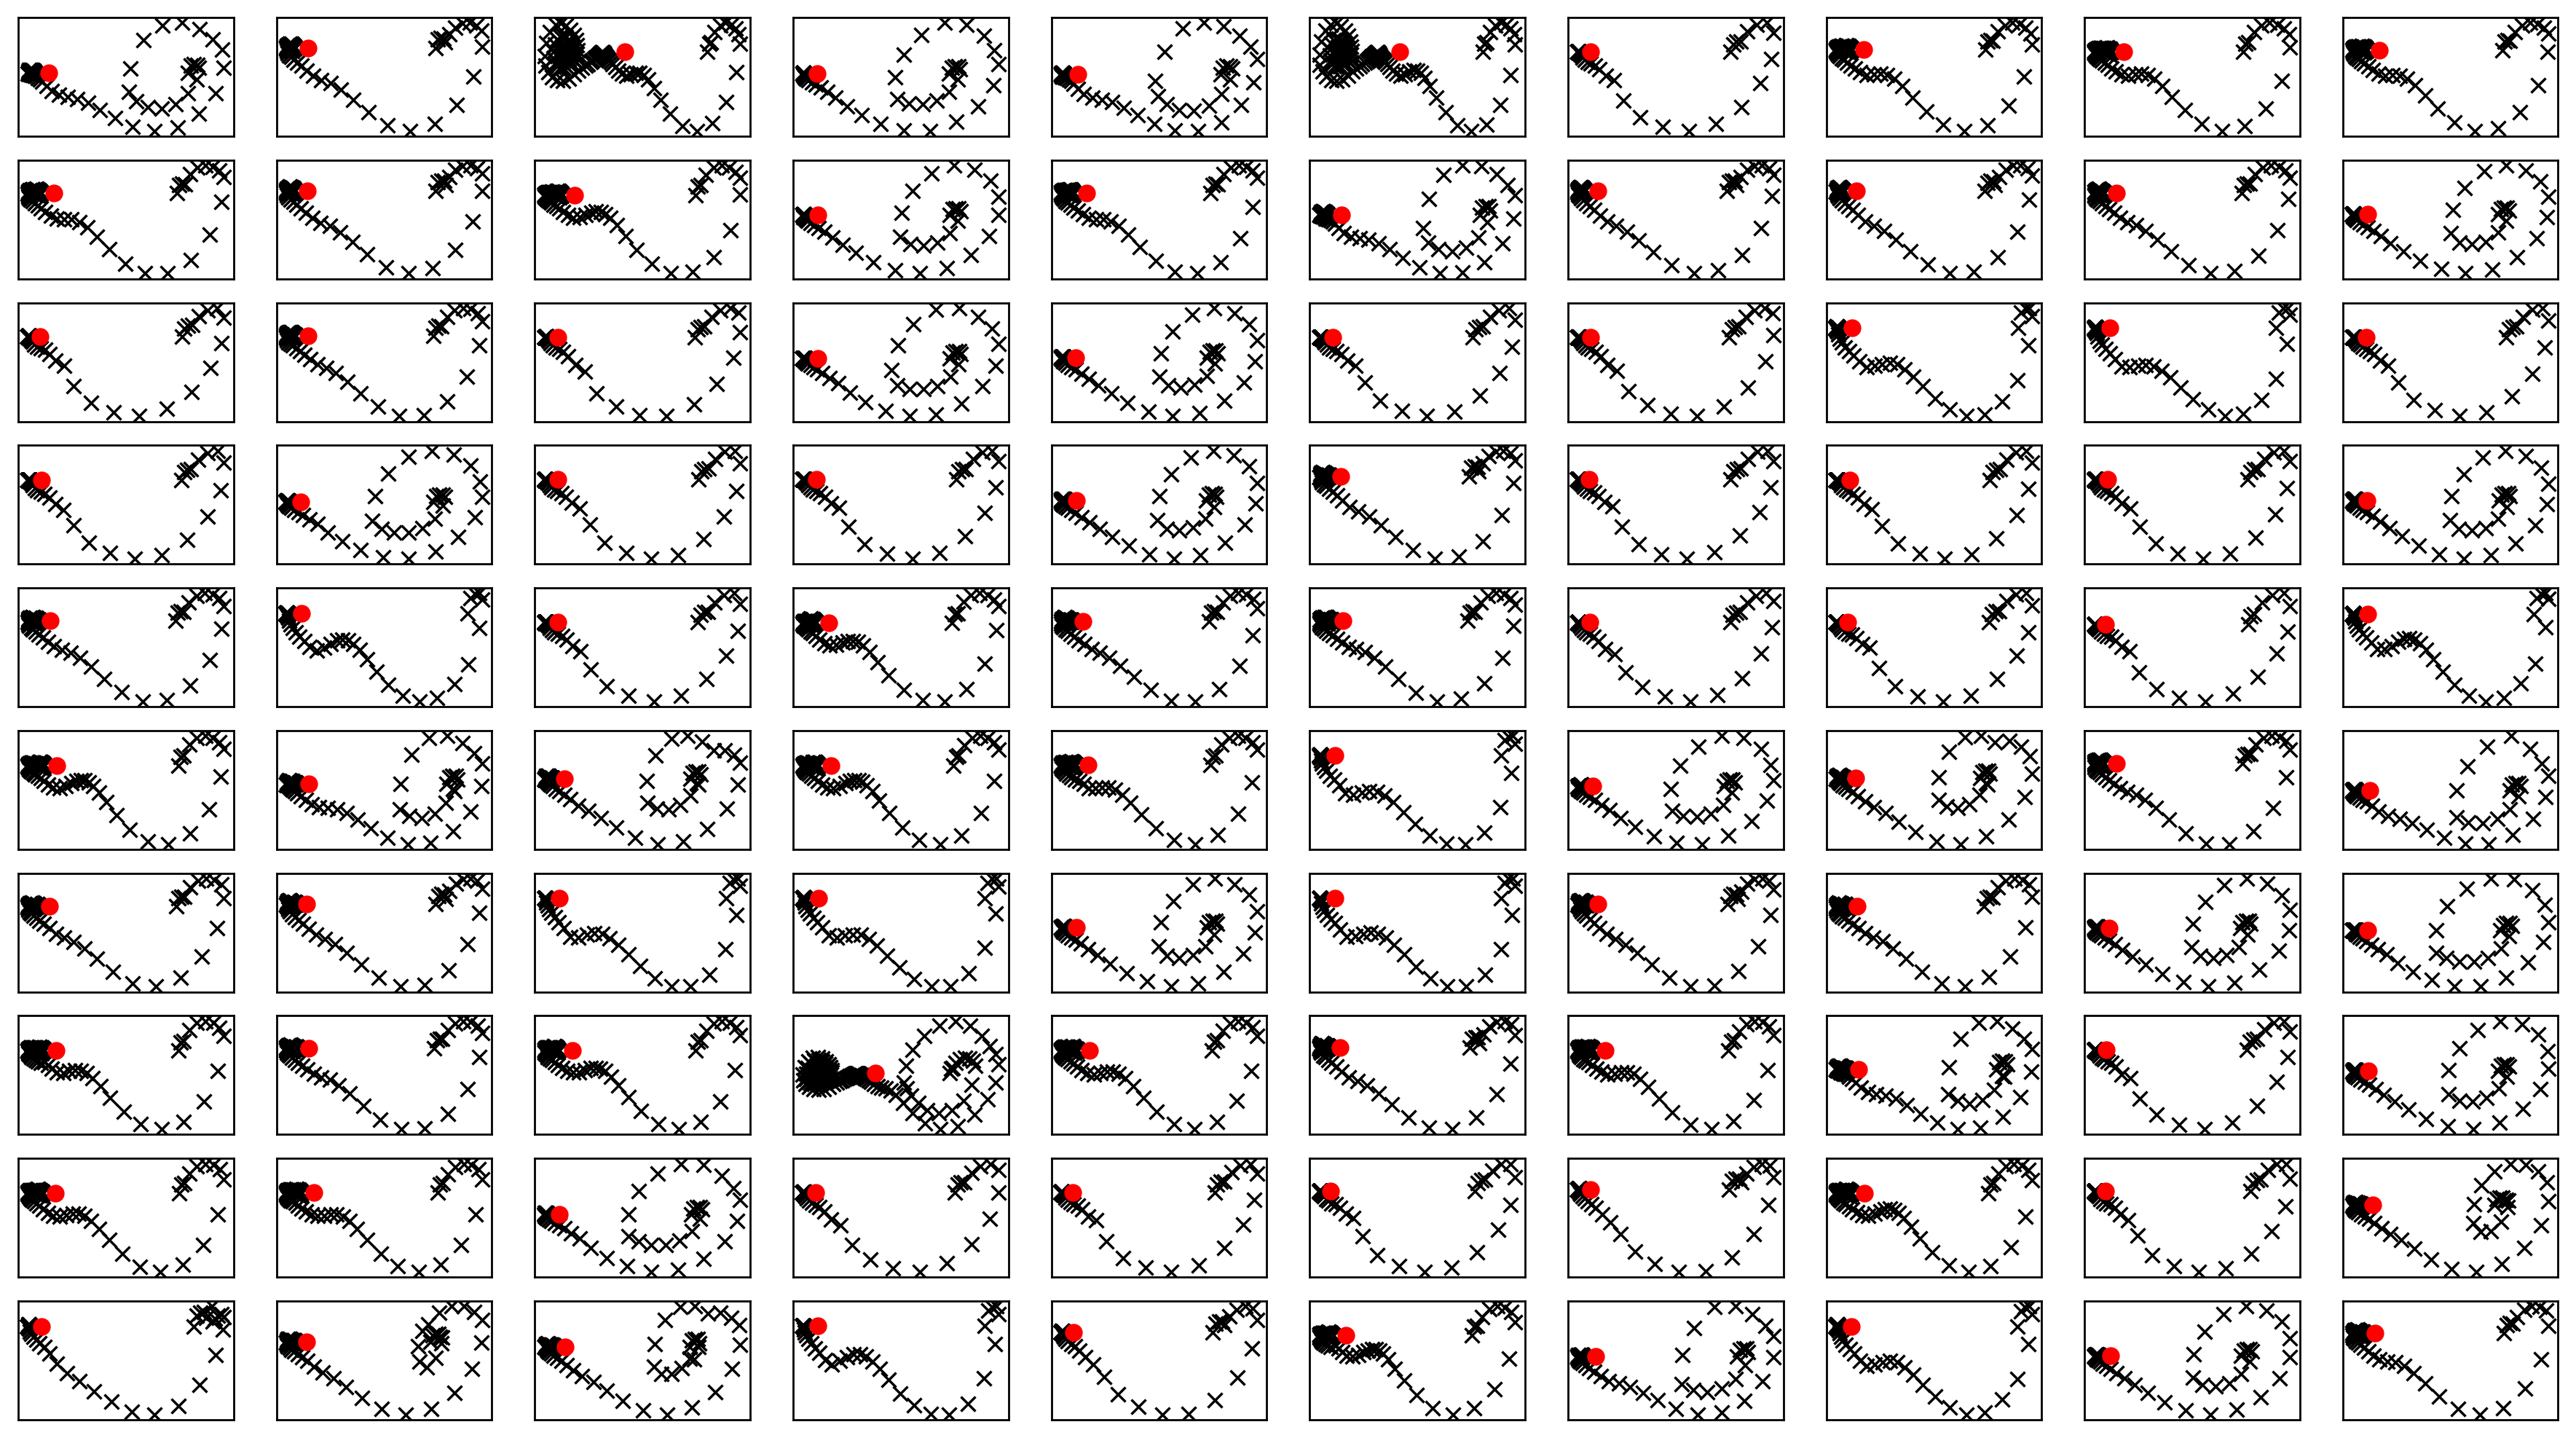

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.show()

In [8]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 4.76837158203125e-07

 1 3.5545125007629395

 2 3.6214568614959717

 3 3.537132501602173

 4 3.556731939315796

 5 3.599787712097168

 6 3.5052671432495117

 7 3.565800428390503

 8 3.5440473556518555

 9 3.6367030143737793

 10 3.498337745666504

 11 3.652523994445801

 12 3.554055690765381

 13 3.741969108581543

 14 3.5075533390045166

 15 3.453178882598877

 16 3.587852716445923

 17 3.597398281097412

 18 3.6020936965942383

 19 3.627243757247925

 20 3.6043365001678467

 21 3.6353652477264404

 22 3.6933114528656006

 23 3.668344497680664

 24 3.5726733207702637

 25 3.7395999431610107

 26 3.657500743865967

 27 3.636040210723877

 28 3.5726535320281982

 29 3.531981945037842

 30 3.573361873626709

 31 3.568452835083008

 32 3.717454433441162

 33 3.4164183139801025

 34 3.5443265438079834

 35 3.6143767833709717

 36 3.510981559753418

 37 3.5531206130981445

 38 3.6422529220581055

 39 3.501028060913086

 40 3.471196413040161

 41 3.473245143890381

 42 3.5646636486053467

実環境方策rollout vs Sim環境方策rollout


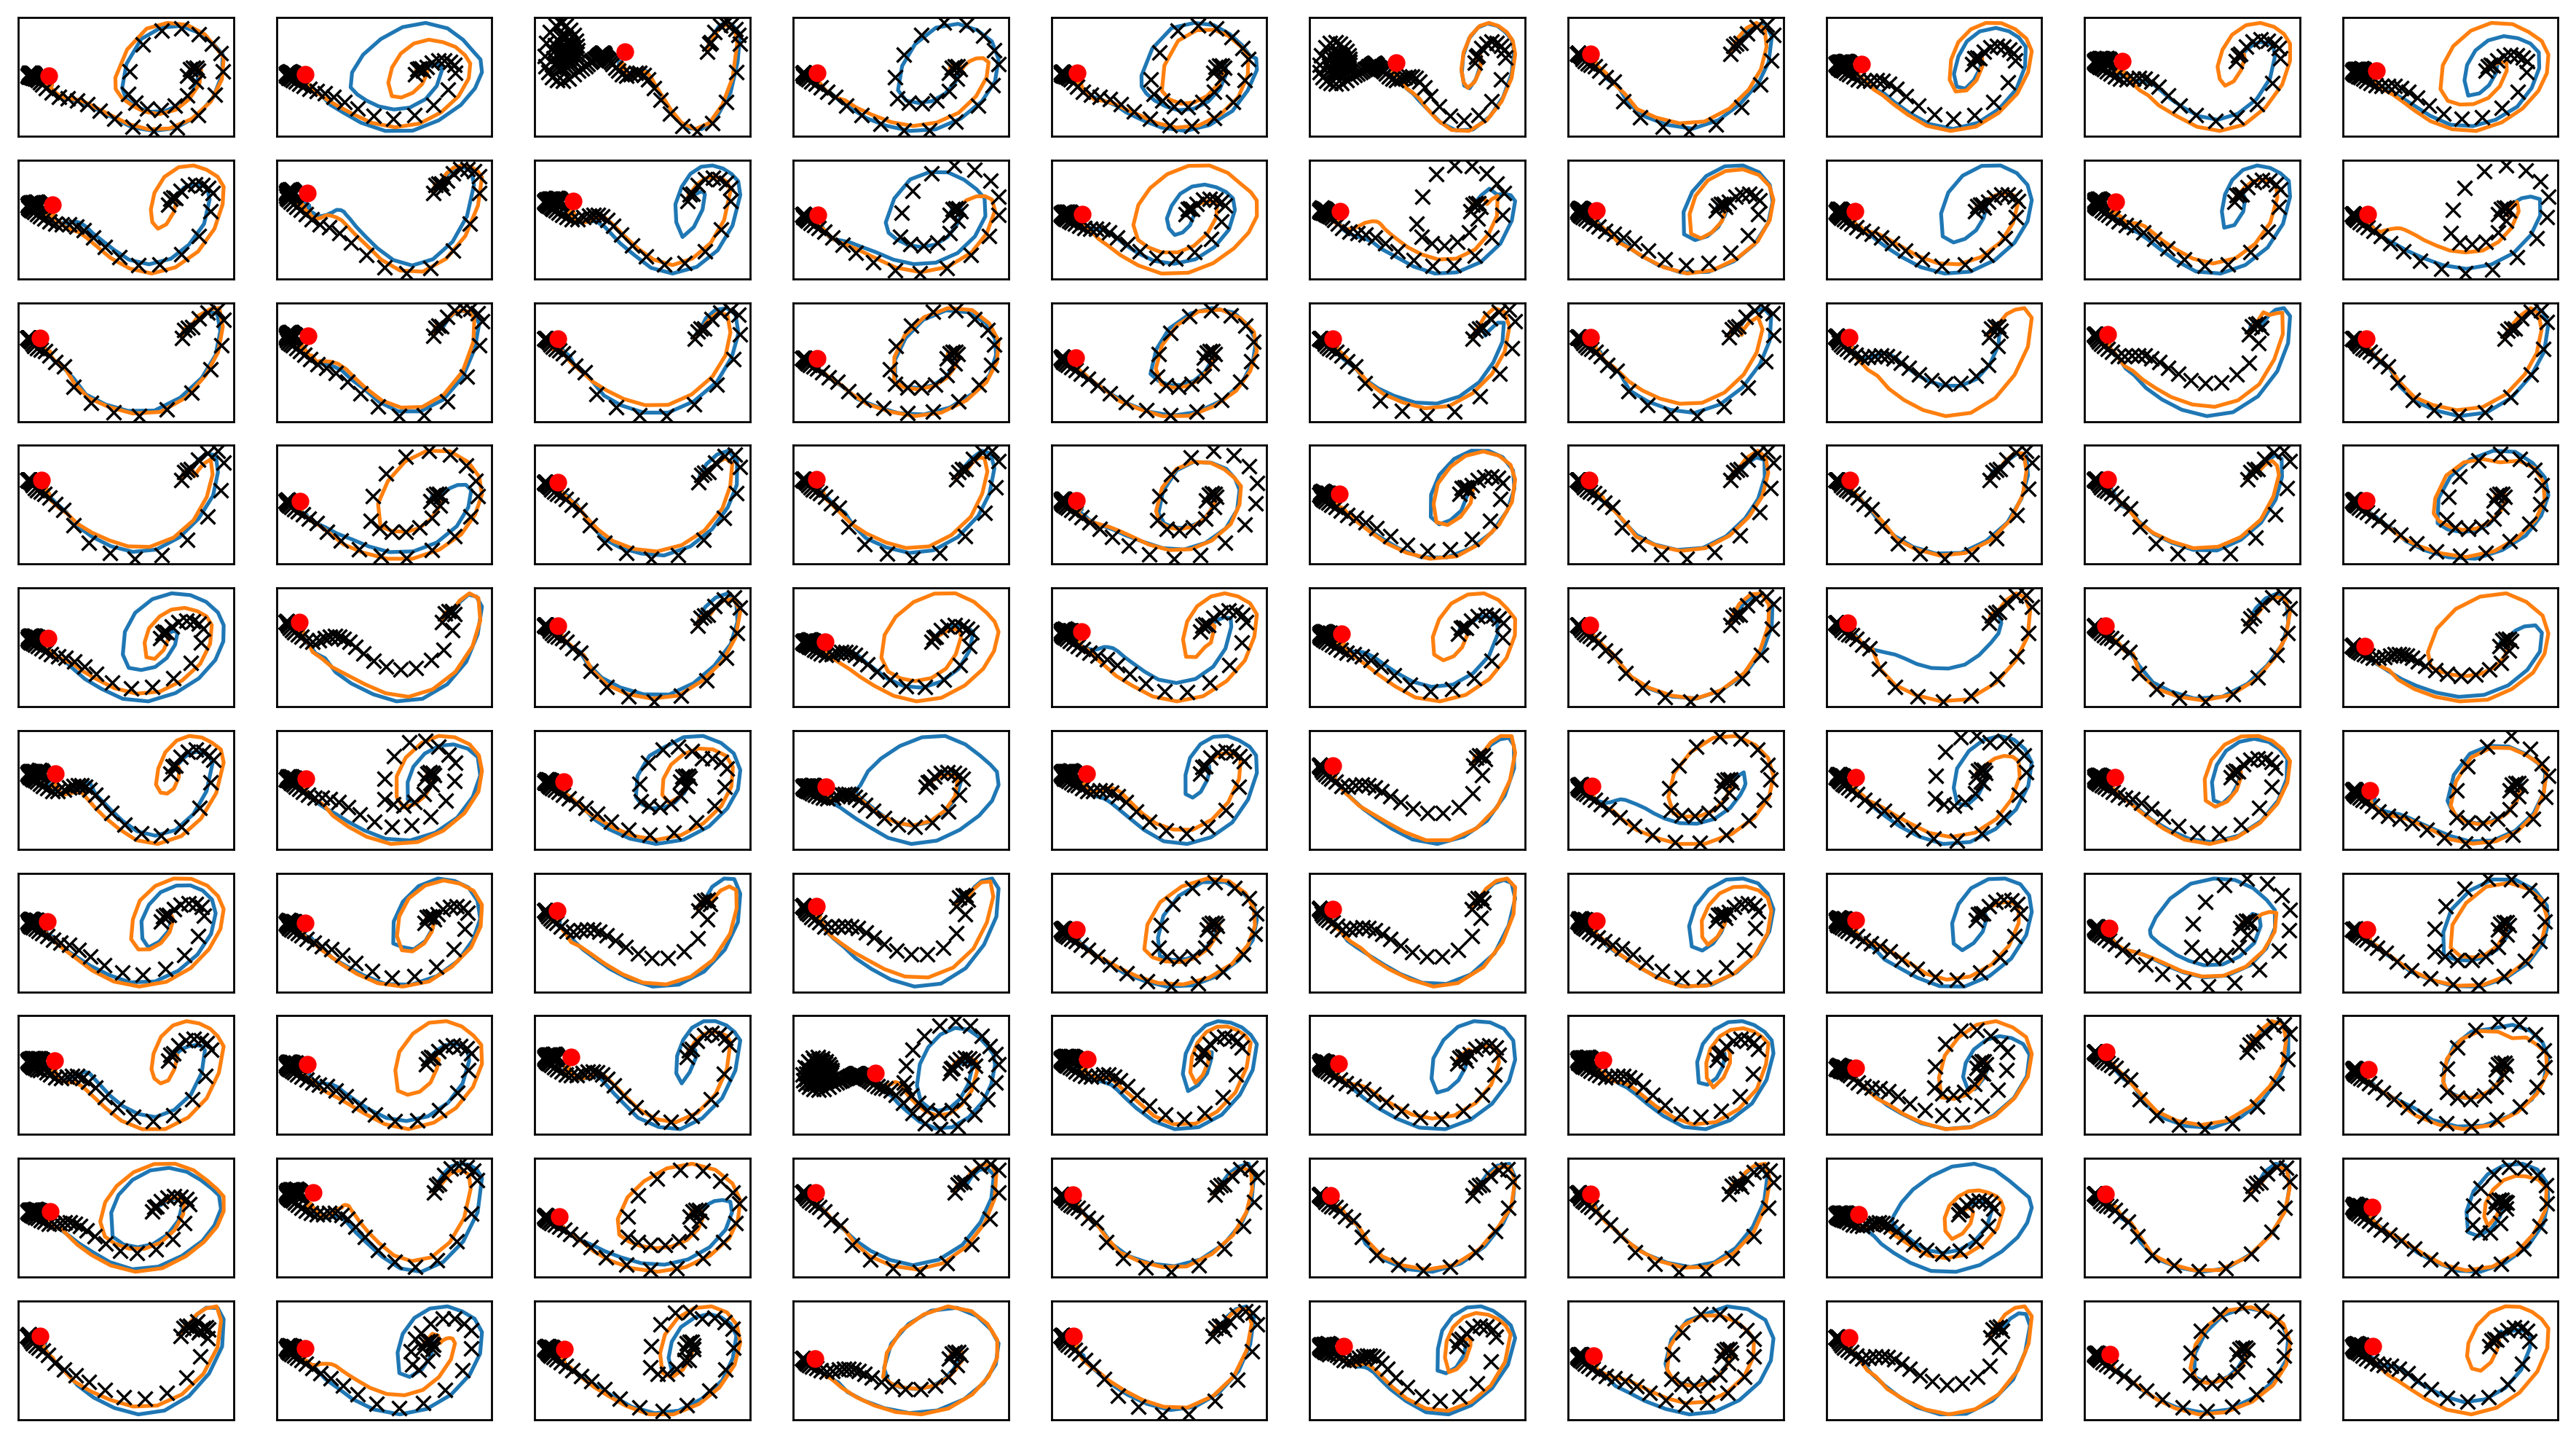

In [9]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [10]:
print(datetime.datetime.now())

2023-06-22 07:55:40.561788
